In [5]:
import warnings

warnings.filterwarnings('ignore', category=Warning)

In [6]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [7]:
from traj_xai.src.xai import TrajectoryManipulator

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_trajectory_by_point_pair_and_coef(segments, coef):
    # Normalize coefficients for color mapping
    normalized_coefs = np.abs(coef).flatten() / np.max(np.abs(coef))
    colors = plt.cm.RdYlGn_r(normalized_coefs)  # Red to Green reversed colormap

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(7, 7))

    # Plot each segment
    for i in range(len(segments)):
        # Convert Vector objects to numpy arrays
        temp = np.array([[p[0], p[1]] for p in segments[i]])  # Extract x, y from Vector

        if i < len(segments) - 1 and len(segments[i + 1]) > 0:
            next_point = np.array(
                [segments[i + 1][0][0], segments[i + 1][0][1]]
            ).reshape(1, 2)
            temp = np.concatenate((temp, next_point), axis=0)

        x_values = temp[:, 0]
        y_values = temp[:, 1]

        ax.plot(x_values, y_values, color=colors[i], linewidth=3)
        ax.scatter(x_values, y_values, c="blue", s=50)  # Add blue points

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array(normalized_coefs)
    fig.colorbar(sm, ax=ax, label="Normalized Importance")

    # Labels and title
    ax.set_title("Trajectory Explanation")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.grid(True)
    ax.set_aspect("equal")
    plt.show()


def explain_and_visualize_sample(
    dataset, segment_func, perturbation_func, model, sample_idx=0
):
    traj_points, traj_time, label = dataset.trajs[sample_idx].r, dataset.trajs[sample_idx].t, dataset.labels[sample_idx]

    if traj_points is None or len(traj_points) == 0:
        print(f"Trajectory {sample_idx} is empty or None.")
        return
    
    if traj_time is None or len(traj_time) == 0:
        print(f"Trajectory {sample_idx} has no temporal component")
        return

    manipulator = TrajectoryManipulator(
        traj_points, segment_func, perturbation_func, model
    )

    coef = manipulator.explain()
    if coef is None:
        print("No meaningful explanation (coef is None).")
        return

    coef = np.array(coef)
    print(f"Explanation coefficients: {coef}")
    if coef.ndim > 1:
        coef = np.mean(coef, axis=0)

    segments = manipulator.get_segment()
    print(f"Segments: {segments}")

    plot_trajectory_by_point_pair_and_coef(segments, coef)

In [9]:
# def explain_and_visualize_sample(
#     dataset, segment_func, perturbation_func, model, sample_idx=0
# ):
#     traj_points, label = dataset.trajs[sample_idx].r, dataset.labels[sample_idx]

#     if traj_points is None or len(traj_points) == 0:
#         print(f"Trajectory {sample_idx} is empty or None.")
#         return

#     manipulator = TrajectoryManipulator(
#         traj_points, segment_func, perturbation_func, model
#     )

#     coef = manipulator.explain()
#     if coef is None:
#         print("No meaningful explanation (coef is None).")
#         return

#     coef = np.array(coef)
#     print(f"Explanation coefficients: {coef}")
#     if coef.ndim > 1:
#         coef = np.mean(coef, axis=0)

#     segments = manipulator.get_segment()
#     print(f"Segments: {segments}")

#     plot_trajectory_by_point_pair_and_coef(segments, coef)

In [10]:
from traj_xai.src import (
    rdp_segmentation,
    gaussian_perturbation,
)
from pactus import Dataset, featurizers
from pactus.models import LSTMModel, RandomForestModel

In [11]:
dataset = Dataset.mnist_stroke()
train, test = dataset.split(0.8, random_state=42)
model = LSTMModel()
# Train the model on the train dataset
model.train(train, dataset, epochs=2, batch_size=64)
# Evaluate the model on a test dataset
evaluation = model.evaluate(test)

Epoch 1/2
875/875 ━━━━━━━━━━━━━━━━━━━━ 99s 109ms/step - accuracy: 0.7472 - loss: 0.8231
Epoch 2/2
875/875 ━━━━━━━━━━━━━━━━━━━━ 99s 113ms/step - accuracy: 0.9029 - loss: 0.3331
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step


18:10:08 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


18:10:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
18:10:15 [INFO] Finished explanation process.


Explanation coefficients: [[ 0.07074002  1.59893832  0.3578116   0.02091871  0.16584363  0.25514688
  -0.35746236  0.41274886  0.1994582  -0.36396739 -0.43788395  0.10608247
   1.09952865  1.43963238 -0.6797162   0.53204111 -0.07391366 -0.03996966
   0.20766062  0.49318866  0.07835806 -0.44162638  0.12693757  0.55157591
   0.28403113  0.19462973  0.12808857  0.18132155]
 [-0.2447485  -1.25651526  0.90960996 -0.74160003  0.33816068 -0.60537979
  -0.27067926  0.81089126  1.05367006 -0.14718719  0.60592673  0.27701558
   0.34902306  2.23314833 -0.7959665   1.12474426 -0.10713019 -0.46423568
  -0.90647189 -0.46164659 -0.06103525 -0.56941025  0.02926743  1.58931525
  -0.41775316  1.27091957 -0.03086712 -0.4754718 ]
 [ 0.80022671 -1.51762701  0.52670496 -0.85115511 -0.05160802  0.21129784
   0.17561013 -0.3043602  -0.96939834 -0.31960726 -0.58977662 -0.33216922
  -0.70179721 -2.55914934  0.54383943 -0.70156729 -0.23946784  0.54403472
  -0.09929373 -0.2541041  -0.04326338  1.2118707   0.16245

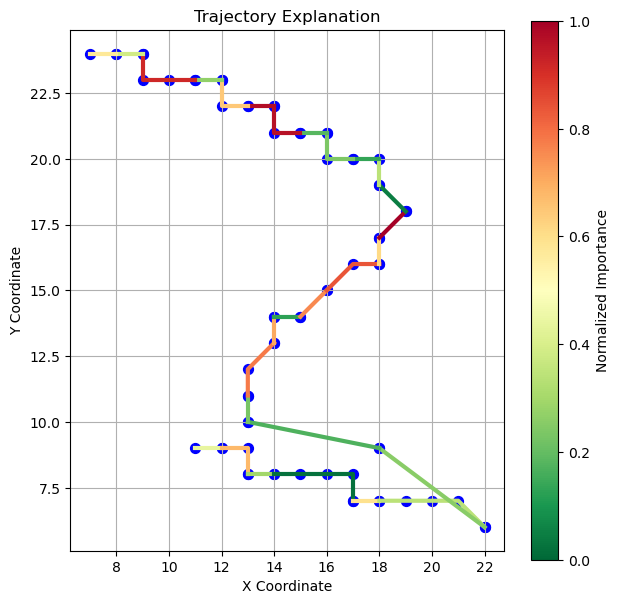

18:10:15 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


18:10:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
18:10:16 [WARNING] Only one class detected, skipping explanation.


No meaningful explanation (coef is None).


18:10:16 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


18:10:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
18:10:17 [WARNING] Only one class detected, skipping explanation.


No meaningful explanation (coef is None).


18:10:17 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


18:10:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
18:10:21 [INFO] Finished explanation process.


Explanation coefficients: [[-2.01704581  2.49340801  0.06976196  0.48964427  0.81977192  2.30119244
  -1.1007784   1.07848113  0.1392942   0.27592857  0.57244596  0.0622682
   1.40880128 -0.55371832  0.19049717 -1.33748733 -0.08143951 -0.30580333
   0.03493186]]
Segments: [[Vector([20.,  7.])], [Vector([19.,  8.])], [Vector([19.,  9.])], [Vector([18., 10.]), Vector([17., 11.])], [Vector([17., 12.])], [Vector([16., 13.])], [Vector([16., 14.])], [Vector([15., 14.])], [Vector([15., 15.])], [Vector([14., 16.])], [Vector([14., 17.])], [Vector([13., 17.])], [Vector([13., 18.]), Vector([13., 19.])], [Vector([12., 19.])], [Vector([12., 20.])], [Vector([11., 21.])], [Vector([11., 22.])], [Vector([10., 23.])], [Vector([11., 24.])]]


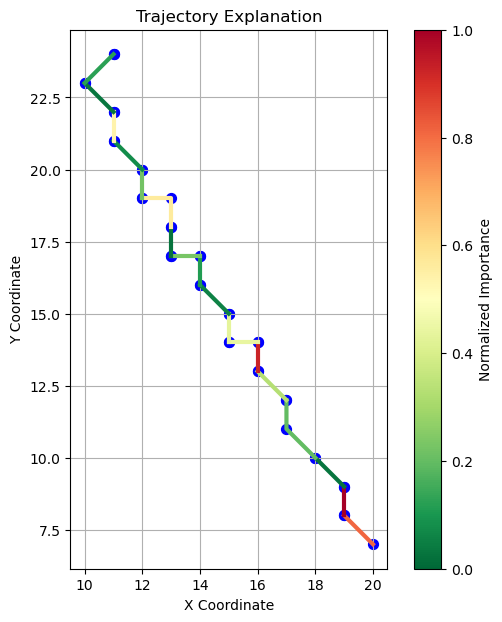

18:10:21 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


18:10:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
18:10:22 [WARNING] Only one class detected, skipping explanation.


No meaningful explanation (coef is None).


18:10:22 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


18:10:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
18:10:30 [INFO] Finished explanation process.


Explanation coefficients: [[ 1.48126636  2.483159    0.5606685   0.07420014  0.06012945  0.29428565
  -0.4195123  -0.07712081 -0.25666354  0.04113346 -0.34296984  0.21989993
   0.57492237 -0.52407208  0.29796295 -0.22335384 -0.4721625   0.27156605
   0.04169807 -0.19385512 -0.23278223  0.22331784  0.17055691 -0.22930388
   0.37606112  0.2564509  -1.85403175  0.46268831  0.70191913 -0.50235349
   0.24036068  1.79493873 -0.19099073  0.83638376  5.83414792  0.46509719]]
Segments: [[Vector([11., 11.])], [Vector([12., 10.])], [Vector([13., 10.])], [Vector([13.,  9.])], [Vector([14.,  9.]), Vector([15.,  9.])], [Vector([15.,  8.])], [Vector([16.,  8.])], [Vector([17.,  7.])], [Vector([18.,  7.])], [Vector([19.,  8.])], [Vector([19.,  9.]), Vector([19., 10.]), Vector([19., 11.]), Vector([19., 12.]), Vector([19., 13.]), Vector([19., 14.])], [Vector([18., 15.])], [Vector([18., 16.])], [Vector([17., 16.])], [Vector([16., 15.])], [Vector([15., 15.]), Vector([14., 15.])], [Vector([13., 16.])], [Ve

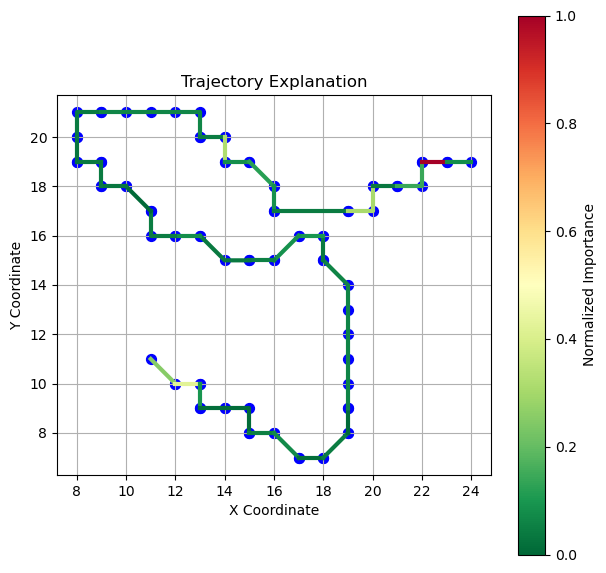

18:10:31 [DEBUG] Starting explanation process...


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


18:10:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 10)
18:10:31 [WARNING] Only one class detected, skipping explanation.
18:10:31 [DEBUG] Starting explanation process...


No meaningful explanation (coef is None).
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


18:10:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
18:10:37 [INFO] Finished explanation process.


Explanation coefficients: [[ 0.04410154  0.29559602 -0.09077171 -0.33999246 -0.33260828 -0.17197284
   0.30830149 -0.79971246 -0.79208833  0.50251854  0.73961542  1.29674976
   0.84001283  2.19681275]
 [ 0.16421517  0.28207662 -0.19357211 -1.56591887  0.43718539  0.29456725
  -0.05829546 -0.70660875 -0.16150837  0.39739603  1.33760483  0.90599453
  -0.065396   -1.91134175]
 [-0.05697119  0.56089947 -0.10885914 -0.26985739 -0.00574675  0.80476886
  -0.34305036  2.17118836  1.51810319 -0.73252794 -2.47381591 -3.20678339
   0.09503549 -0.08461147]
 [ 0.23896228 -0.55972884  0.7098175   0.64366436 -0.35828257 -0.47443368
  -0.18121097 -0.25060309 -0.12215994 -0.18911744 -0.80647973  0.17003049
  -0.35648967  0.73987437]
 [-0.3903078  -0.57884327 -0.31661455  1.53210437  0.25945221 -0.45292958
   0.2742553  -0.41426405 -0.44234654  0.0217308   1.20307539  0.83400861
  -0.51316265 -0.9407339 ]]
Segments: [[Vector([12.,  8.])], [Vector([13.,  8.])], [Vector([14.,  7.])], [Vector([15.,  7.]), 

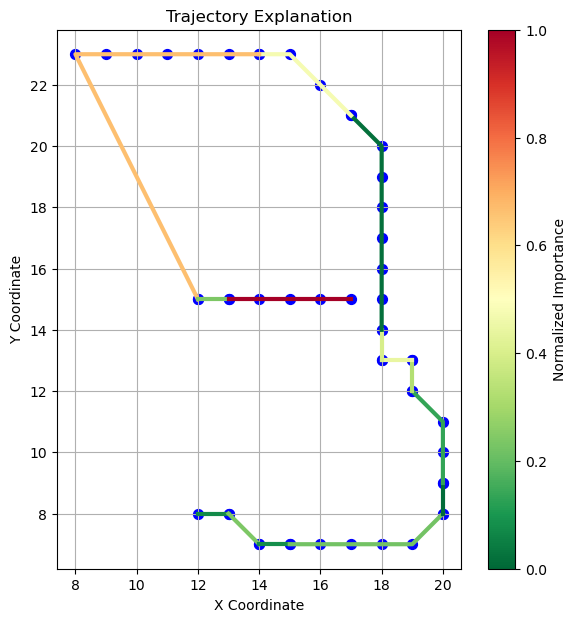

18:10:37 [DEBUG] Starting explanation process...


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


18:10:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 10)
18:10:37 [WARNING] Only one class detected, skipping explanation.
18:10:37 [DEBUG] Starting explanation process...


No meaningful explanation (coef is None).
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


18:10:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
18:10:43 [INFO] Finished explanation process.


Explanation coefficients: [[ 1.16165227 -0.41280018  1.4024917  -0.52527318  1.30068482 -0.49063338
  -1.30739327  0.7510199  -0.12921227 -0.090789    0.39940888 -0.02742064
  -0.36021423  0.05765787  0.48298796 -0.12026528  0.08076362 -0.09148735
   0.04225617  0.18808284 -0.16170209  0.03458656  0.20775501 -0.02619266
  -0.17916985  0.08111951]
 [-1.23375113  0.50946328 -1.46830678  0.6109924  -1.37368681  0.56996482
   1.17569744 -0.82973602  0.02949572 -0.01147205 -0.48945459 -0.07857186
   0.25373095  0.046452   -0.57653898  0.21784446  0.02150709 -0.00888414
   0.05860763 -0.0748123   0.04732809  0.0575061  -0.1148436  -0.079193
   0.0723496  -0.18887365]
 [ 0.07209886 -0.0966631   0.06581508 -0.08571922  0.07300199 -0.07933145
   0.13169583  0.07871612  0.09971656  0.10226105  0.09004571  0.1059925
   0.10648328 -0.10410987  0.09355102 -0.09757919 -0.10227071  0.10037149
  -0.10086379 -0.11327054  0.114374   -0.09209266 -0.09291141  0.10538565
   0.10682025  0.10775415]]
Segment

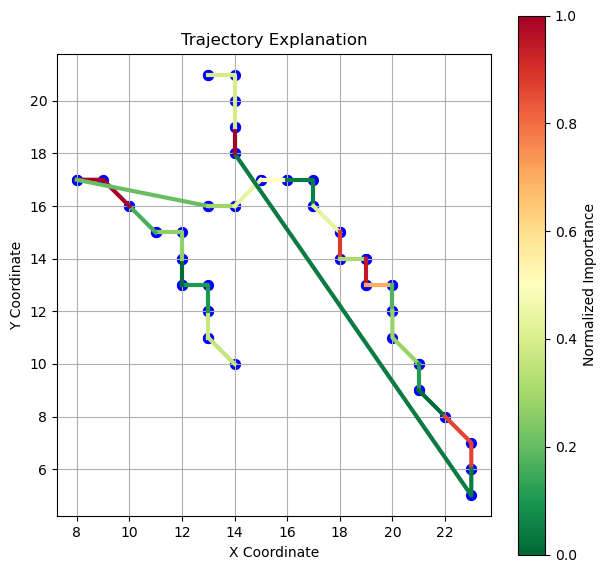

In [13]:
limit = 10  # float('inf')

for i in range(min(limit, len(train.trajs))):
    if train.trajs[i].r is None or len(train.trajs[i].r) == 0:
        print(f"Trajectory {i} is empty or None.")
        continue
    # Giải thích và trực quan hóa mẫu đầu tiên
    explain_and_visualize_sample(
        dataset,
        segment_func=rdp_segmentation,
        perturbation_func=gaussian_perturbation,
        model=model,
        sample_idx=i,
    )